# To use the model with HuggingFace

In [1]:
from huggingface_hub import hf_hub_download
from keras.models import load_model
model_path = hf_hub_download(repo_id="Ali-Abdelhamid-Ali/The_Best_3D_Brain_Tumor_Segmentation_BraTS_2021",filename="The Best 3D Brain MRI Segmentation.keras")
model = load_model(model_path, compile=False)
model.summary()

c:\Users\Legion\anaconda3\envs\TF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model: "Advanced_3D_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                12, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 112, 112, 11  3488        ['input_1[0][0]']                
                                2, 32)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 11  128        ['conv3d[0][0]']                 
 alization)                     2, 32)                                            

## 1. Imports

This section contains all necessary libraries to run the code. They are organized for clarity and efficiency, including only essential tools.

In [1]:
import warnings
from pathlib import Path
from typing import Dict, Tuple, List

import json
import numpy as np
import pandas as pd
import nibabel as nib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Conv3DTranspose, Input,
    BatchNormalization, Activation, SpatialDropout3D, concatenate
)
from tensorflow.keras import regularizers, initializers
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')


## 2. Data Preprocessing

Data preprocessing ensures quality and standardization before training. Functions below handle NIfTI loading, intensity normalization, cropping to ROI, and mask re-encoding.

In [2]:
USE_FLOAT16 = True
MODALITIES = ["t1", "t1ce", "t2", "flair"]

def load_nifti_canonical(path: Path) -> Tuple[np.ndarray, np.ndarray, dict]:
    nii = nib.as_closest_canonical(nib.load(str(path)))
    data = nii.get_fdata(dtype=np.float32)
    affine = nii.affine
    header = {k: nii.header[k].tolist() if k in nii.header else None for k in ["dim", "pixdim"]}
    return data, affine, header

def normalize_nonzero(volume: np.ndarray) -> np.ndarray:
    vol = volume.astype(np.float32)
    nz = vol[vol != 0]
    if nz.size > 0:
        mean, std = float(nz.mean()), float(nz.std())
    else:
        mean, std = float(vol.mean()), float(vol.std())
    vol = (vol - mean) / (std + 1e-8)
    return vol

def preprocess_mask_multiclass(mask: np.ndarray) -> np.ndarray:
    m = np.rint(mask).astype(np.uint8)
    m[m == 4] = 3
    return m

def crop_to_roi(image: np.ndarray, mask: np.ndarray, margin: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    coords = np.array(np.nonzero(mask))
    if coords.size == 0:
        return image, mask
    zmin, ymin, xmin = coords.min(axis=1)
    zmax, ymax, xmax = coords.max(axis=1)
    zmin = max(zmin - margin, 0)
    ymin = max(ymin - margin, 0)
    xmin = max(xmin - margin, 0)
    zmax = min(zmax + margin, mask.shape[0] - 1)
    ymax = min(ymax + margin, mask.shape[1] - 1)
    xmax = min(xmax + margin, mask.shape[2] - 1)
    img_c = image[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
    msk_c = mask[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
    return img_c, msk_c

def process_one_patient(patient_folder: Path, patient_id: str) -> Tuple[np.ndarray, np.ndarray, Dict]:
    mask_path = patient_folder / f"{patient_id}_seg.nii.gz"
    if not mask_path.exists():
        raise FileNotFoundError(f"Mask file not found: {mask_path}")
    mask_vol, aff_m, hdr_m = load_nifti_canonical(mask_path)
    mask = preprocess_mask_multiclass(mask_vol)

    vols = []
    metas = {"patient_id": patient_id, "modalities": MODALITIES}
    for mod in MODALITIES:
        p = patient_folder / f"{patient_id}_{mod}.nii.gz"
        if not p.exists():
            raise FileNotFoundError(f"File not found: {p}")
        vol, aff, hdr = load_nifti_canonical(p)
        vols.append(vol)
        metas[f"affine_{mod}"] = aff.tolist()
        metas[f"header_{mod}"] = hdr

    shapes = [v.shape for v in vols]
    if len(set(shapes)) != 1:
        raise ValueError(f"[AlignmentError] Modality shapes differ for patient {patient_id}: {shapes}")

    image_4ch = np.stack(vols, axis=-1)
    image_4ch, mask = crop_to_roi(image_4ch, mask)

    for i in range(image_4ch.shape[-1]):
        image_4ch[..., i] = normalize_nonzero(image_4ch[..., i])

    if USE_FLOAT16:
        image_4ch = image_4ch.astype(np.float16)

    metas["affine_mask"] = aff_m.tolist()
    metas["header_mask"] = hdr_m
    metas["shape"] = list(mask.shape)

    return image_4ch, mask, metas


## 3. Data Generator

The `BraTSDataGenerator` loads data, extracts 3D patches, and applies simple augmentations. It also tries to sample patches that include tumor voxels for effective training.

In [3]:
import math

def pad_to_min_shape(arr, min_shape, pad_value=0):
    pad_width = []
    for i, s in enumerate(arr.shape[:3]):
        needed = max(0, min_shape[i] - s)
        before = needed // 2
        after = needed - before
        pad_width.append((before, after))
    if arr.ndim == 4:
        pad_width.append((0, 0))
    return np.pad(arr, pad_width, mode='constant', constant_values=pad_value)

def extract_patch(image, mask, patch_size, center=None):
    h, w, d = image.shape[:3]
    ph, pw, pd = patch_size

    if h < ph or w < pw or d < pd:
        image_p = pad_to_min_shape(image, patch_size, pad_value=0)
        mask_p = pad_to_min_shape(mask, patch_size, pad_value=0)
        h, w, d = image_p.shape[:3]
        y = (h - ph) // 2
        x = (w - pw) // 2
        z = (d - pd) // 2
        return image_p[y:y+ph, x:x+pw, z:z+pd], mask_p[y:y+ph, x:x+pw, z:z+pd]

    if center is None:
        y = np.random.randint(0, h - ph + 1)
        x = np.random.randint(0, w - pw + 1)
        z = np.random.randint(0, d - pd + 1)
    else:
        cy, cx, cz = center
        y = np.clip(cy - ph // 2, 0, h - ph)
        x = np.clip(cx - pw // 2, 0, w - pw)
        z = np.clip(cz - pd // 2, 0, d - pd)

    return image[y:y+ph, x:x+pw, z:z+pd], mask[y:y+ph, x:x+pw, z:z+pd]

def random_flip_3d(img, msk):
    for axis in [0, 1, 2]:
        if np.random.rand() < 0.5:
            img = np.flip(img, axis=axis)
            msk = np.flip(msk, axis=axis)
    return img, msk

def intensity_jitter(img, shift_limit=0.1, scale_limit=0.1):
    out = img.astype(np.float32)
    for c in range(out.shape[-1]):
        scale = 1.0 + np.random.uniform(-scale_limit, scale_limit)
        shift = np.random.uniform(-shift_limit, shift_limit)
        out[..., c] = out[..., c] * scale + shift
    return out

def add_noise(img, std=0.02):
    noise = np.random.normal(0, std, size=img.shape).astype(np.float32)
    return img + noise

class BraTSDataGenerator(keras.utils.Sequence):
    def __init__(self, df, patch_size, batch_size=1, augment=False, shuffle=True, min_tumor_frac=0.01):
        self.df = df.reset_index(drop=True)
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.min_tumor_frac = min_tumor_frac
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((self.batch_size, *self.patch_size, 4), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.patch_size, 1), dtype=np.uint8)

        for i, ridx in enumerate(idxs):
            row = self.df.iloc[ridx]
            image = np.load(row['image_path']).astype(np.float32)
            mask = np.load(row['mask_path']).astype(np.uint8)

            tries = 0
            patch_img, patch_msk = None, None
            while tries < 10:
                tumor_coords = np.argwhere(mask > 0)
                if tumor_coords.size > 0:
                    cy, cx, cz = tumor_coords[np.random.randint(0, len(tumor_coords))]
                    center = (cy, cx, cz)
                else:
                    center = None
                patch_img, patch_msk = extract_patch(image, mask, self.patch_size, center=center)
                frac = (patch_msk > 0).mean()
                if frac >= self.min_tumor_frac or tumor_coords.size == 0:
                    break
                tries += 1

            if self.augment:
                patch_img, patch_msk = random_flip_3d(patch_img, patch_msk)
                if np.random.rand() < 0.5:
                    patch_img = intensity_jitter(patch_img)
                if np.random.rand() < 0.5:
                    patch_img = add_noise(patch_img)

            X[i] = patch_img
            y[i] = np.expand_dims(patch_msk, axis=-1)

        return X, y


## 4. Model Architecture

3D U-Net with Conv3DTranspose, BatchNormalization, and SpatialDropout3D to improve performance and reduce overfitting.

In [4]:
def conv_block(inputs, num_filters, kernel_size=3, initializer='he_normal', regularizer=None):
    x = layers.Conv3D(num_filters, kernel_size, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(num_filters, kernel_size, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def decoder_block(inputs, skip_features, num_filters, kernel_size=3, strides=2, initializer='he_normal', regularizer=None):
    x = layers.Conv3DTranspose(num_filters, kernel_size, strides=(strides, strides, strides), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters, kernel_size, initializer, regularizer)
    return x

def create_advanced_3d_unet(input_shape, num_classes=4):
    reg = regularizers.l2(1e-5)

    inputs = Input(input_shape)

    s1 = conv_block(inputs, 32, regularizer=reg)
    p1 = layers.MaxPooling3D((2, 2, 2))(s1)
    p1 = SpatialDropout3D(0.05)(p1)

    s2 = conv_block(p1, 64, regularizer=reg)
    p2 = layers.MaxPooling3D((2, 2, 2))(s2)
    p2 = SpatialDropout3D(0.1)(p2)

    s3 = conv_block(p2, 128, regularizer=reg)
    p3 = layers.MaxPooling3D((2, 2, 2))(s3)
    p3 = SpatialDropout3D(0.15)(p3)

    s4 = conv_block(p3, 256, regularizer=reg)
    p4 = layers.MaxPooling3D((2, 2, 2))(s4)
    p4 = SpatialDropout3D(0.2)(p4)

    b1 = conv_block(p4, 512, regularizer=reg)

    d1 = decoder_block(b1, s4, 256, regularizer=reg)
    d2 = decoder_block(d1, s3, 128, regularizer=reg)
    d3 = decoder_block(d2, s2, 64, regularizer=reg)
    d4 = decoder_block(d3, s1, 32, regularizer=reg)

    outputs = layers.Conv3D(num_classes, 1, activation='softmax')(d4)

    model = Model(inputs=[inputs], outputs=[outputs], name='Advanced_3D_U-Net')
    return model


## 5. Loss Functions and Metrics

Combined Dice + CE loss and standard BraTS metrics for Whole Tumor (WT), Tumor Core (TC), and Enhancing Tumor (ET).

In [ ]:
SMOOTH = 1e-6

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return (2. * inter + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.squeeze(y_true, axis=-1)  
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)  
    y_pred_arg = K.argmax(y_pred, axis=-1)
    y_pred_oh = tf.one_hot(y_pred_arg, depth=num_classes)
    intersection = K.sum(y_true_oh * y_pred_oh, axis=[0,1,2,3])
    union = K.sum(y_true_oh + y_pred_oh, axis=[0,1,2,3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return K.mean(iou)


def combined_dice_ce_loss(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    dice_sum = 0.0
    for c in range(1, num_classes):
        dice_sum += dice_coef(y_true_oh[..., c], y_pred[..., c])
    dice_mean = dice_sum / tf.cast(num_classes - 1, tf.float32)
    ce = K.categorical_crossentropy(y_true_oh, y_pred)
    ce_mean = K.mean(ce)
    return 0.5 * (1.0 - dice_mean) + 0.5 * ce_mean

def dice_whole_tumor(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred_arg = K.argmax(y_pred, axis=-1)

    y_true_wt = K.cast(K.any(y_true_oh[..., 1:], axis=-1), 'float32')
    y_pred_wt = K.cast(K.any(tf.stack([tf.equal(y_pred_arg, 1), tf.equal(y_pred_arg, 2), tf.equal(y_pred_arg, 3)], axis=-1), axis=-1), 'float32')
    return dice_coef(y_true_wt, y_pred_wt)

def dice_tumor_core(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred_arg = K.argmax(y_pred, axis=-1)

    y_true_tc = K.cast(K.any(tf.stack([y_true_oh[..., 1], y_true_oh[..., 3]], axis=-1), axis=-1), 'float32')
    y_pred_tc = K.cast(K.any(tf.stack([tf.equal(y_pred_arg, 1), tf.equal(y_pred_arg, 3)], axis=-1), axis=-1), 'float32')
    return dice_coef(y_true_tc, y_pred_tc)

def dice_enhancing_tumor(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred_arg = K.argmax(y_pred, axis=-1)

    y_true_et = y_true_oh[..., 3]
    y_pred_et = K.cast(tf.equal(y_pred_arg, 3), 'float32')
    return dice_coef(y_true_et, y_pred_et)


## 6. Data Loading, Splitting and Training Setup

This section loads the dataset, preprocesses and saves .npy files, splits into train/val/test, and prepares the model and callbacks.

In [ ]:
DATA_DIR = Path(r"D:\IBM Aspera\new\new-not-previously-in-TCIA")  
SAVE_DIR = Path(r"D:\New BraTS_preprocessed_npy_new")  
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# --- Data Loading and Preprocessing ---
def run_preprocessing(data_dir: Path, save_dir: Path) -> pd.DataFrame:
    patient_folders = [p for p in data_dir.iterdir() if p.is_dir()]
    records = []
    for p_folder in patient_folders:
        patient_id = p_folder.name
        try:
            img, msk, meta = process_one_patient(p_folder, patient_id)
            
            img_path = save_dir / f"{patient_id}_img.npy"
            msk_path = save_dir / f"{patient_id}_msk.npy"
            meta_path = save_dir / f"{patient_id}_meta.json"

            np.save(img_path, img)
            np.save(msk_path, msk)
            with open(meta_path, 'w') as f:
                json.dump(meta, f)

            records.append({
                'patient_id': patient_id,
                'image_path': str(img_path),
                'mask_path': str(msk_path),
                'meta_path': str(meta_path)
            })
        except Exception as e:
            print(f"Error processing patient {patient_id}: {e}")
    return pd.DataFrame(records)

# Check if preprocessing has been done, otherwise run it
preprocessed_manifest = SAVE_DIR / "manifest.csv"
if not preprocessed_manifest.exists():
    print("Running preprocessing...")
    df = run_preprocessing(DATA_DIR, SAVE_DIR)
    df.to_csv(preprocessed_manifest, index=False)
else:
    print("Loading preprocessed manifest...")
    df = pd.read_csv(preprocessed_manifest)

# --- Data Splitting ---
print(f"Total patients: {len(df)}")
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

# Rename for consistency with generator
train = train_df
val = val_df
test = test_df

# --- Training Setup ---
# Hyperparameters
PATCH_SIZE = (112, 112, 112)
BATCH_SIZE = 1
NUM_CLASSES = 4
EPOCHS = 200

# Initialize Data Generators
train_gen = BraTSDataGenerator(train, patch_size=PATCH_SIZE, batch_size=BATCH_SIZE, augment=True, shuffle=True)
val_gen = BraTSDataGenerator(val, patch_size=PATCH_SIZE, batch_size=BATCH_SIZE, augment=False, shuffle=False)

# Create and Compile Model
model = create_advanced_3d_unet(input_shape=(*PATCH_SIZE, 4), num_classes=NUM_CLASSES)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=combined_dice_ce_loss,
    metrics=[dice_whole_tumor, dice_tumor_core, dice_enhancing_tumor, iou_coef]
)

model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint(
    'best_3d_unet_model_All_Data.keras',
    monitor='val_dice_whole_tumor',
    mode='max',
    save_best_only=True,
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1)
callbacks = [early_stop, checkpoint, lr_scheduler]


Running preprocessing...
Error processing patient BraTS2021_00114: Mask file not found: D:\IBM Aspera\new\new-not-previously-in-TCIA\BraTS2021_00114\BraTS2021_00114_seg.nii.gz
Error processing patient BraTS2021_00119: Mask file not found: D:\IBM Aspera\new\new-not-previously-in-TCIA\BraTS2021_00119\BraTS2021_00119_seg.nii.gz
Error processing patient BraTS2021_00125: Mask file not found: D:\IBM Aspera\new\new-not-previously-in-TCIA\BraTS2021_00125\BraTS2021_00125_seg.nii.gz
Error processing patient BraTS2021_00129: Mask file not found: D:\IBM Aspera\new\new-not-previously-in-TCIA\BraTS2021_00129\BraTS2021_00129_seg.nii.gz
Error processing patient BraTS2021_00135: Mask file not found: D:\IBM Aspera\new\new-not-previously-in-TCIA\BraTS2021_00135\BraTS2021_00135_seg.nii.gz
Error processing patient BraTS2021_00141: Mask file not found: D:\IBM Aspera\new\new-not-previously-in-TCIA\BraTS2021_00141\BraTS2021_00141_seg.nii.gz
Error processing patient BraTS2021_00145: Mask file not found: D:\IBM

## 7. Training Execution

Start training using the prepared generators. The learning rate is adjusted and the best model is saved automatically.

In [7]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/200
644/644 [==============================] - ETA: 0s - loss: 0.6404 - dice_whole_tumor: 0.8165 - dice_tumor_core: 0.6307 - dice_enhancing_tumor: 0.6033 - iou_coef: 0.5707
Epoch 1: val_dice_whole_tumor improved from -inf to 0.88376, saving model to best_3d_unet_model_All_Data.keras
644/644 [==============================] - 429s 646ms/step - loss: 0.6404 - dice_whole_tumor: 0.8165 - dice_tumor_core: 0.6307 - dice_enhancing_tumor: 0.6033 - iou_coef: 0.5707 - val_loss: 0.4674 - val_dice_whole_tumor: 0.8838 - val_dice_tumor_core: 0.7703 - val_dice_enhancing_tumor: 0.7502 - val_iou_coef: 0.6548 - lr: 1.0000e-04
Epoch 2/200
644/644 [==============================] - ETA: 0s - loss: 0.3933 - dice_whole_tumor: 0.8852 - dice_tumor_core: 0.7653 - dice_enhancing_tumor: 0.7284 - iou_coef: 0.6687
Epoch 2: val_dice_whole_tumor improved from 0.88376 to 0.89268, saving model to best_3d_unet_model_All_Data.keras
644/644 [==============================] - 402s 624ms/step - loss: 0.3933 - dice_

## 8. Evaluation

Load the best model and evaluate on the held-out test set.

In [9]:
test_gen = BraTSDataGenerator(test, patch_size=PATCH_SIZE, batch_size=BATCH_SIZE, augment=False, shuffle=False)

best_model = keras.models.load_model(
    'best_3d_unet_model_All_Data.keras',
    custom_objects={
        'combined_dice_ce_loss': combined_dice_ce_loss,
        'dice_whole_tumor': dice_whole_tumor,
        'dice_tumor_core': dice_tumor_core,
        'dice_enhancing_tumor': dice_enhancing_tumor,
        'iou_coef': iou_coef
    }
)

print('Evaluating on Test Set...')
scores = best_model.evaluate(test_gen)
print(f'Test Loss: {scores[0]:.4f}')
print(f'Test Dice (Whole Tumor): {scores[1]:.4f}')
print(f'Test Dice (Tumor Core): {scores[2]:.4f}')
print(f'Test Dice (Enhancing Tumor): {scores[3]:.4f}')
print(f'Test IoU (Overall): {scores[4]:.4f}')


Evaluating on Test Set...
139/139 [==============================] - 26s 179ms/step - loss: 0.1721 - dice_whole_tumor: 0.9221 - dice_tumor_core: 0.8246 - dice_enhancing_tumor: 0.8237 - iou_coef: 0.7796
Test Loss: 0.1721
Test Dice (Whole Tumor): 0.9221
Test Dice (Tumor Core): 0.8246
Test Dice (Enhancing Tumor): 0.8237
Test IoU (Overall): 0.7796


## 9. Visualization (Optional)
Visualization utilities to inspect predictions visually can be added here.

1/1 [==============================] - 0s 38ms/step


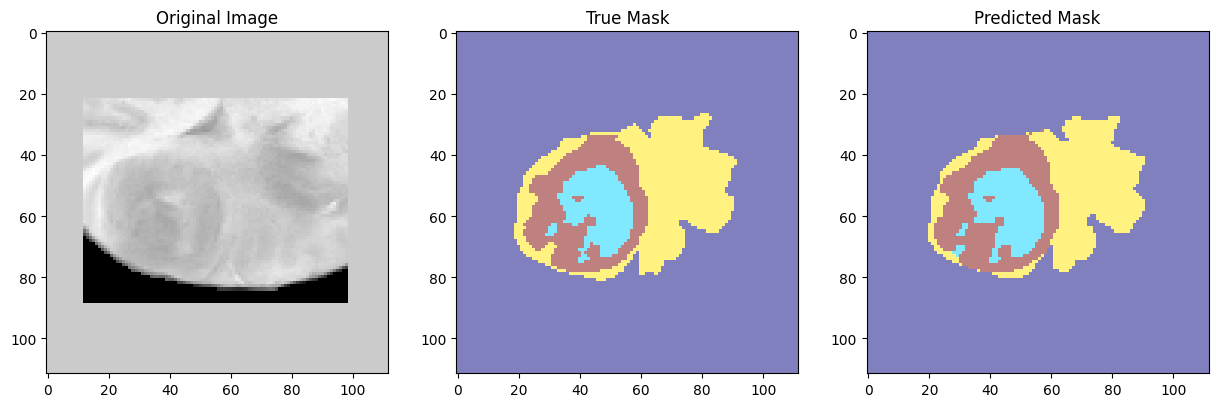

1/1 [==============================] - 0s 26ms/step


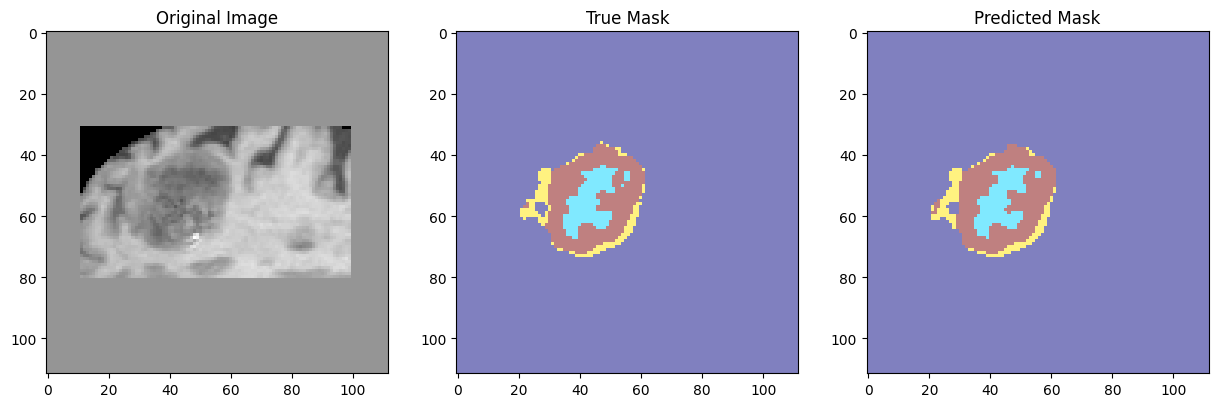

In [12]:
import matplotlib.pyplot as plt
def plot_segmentation_results(image, true_mask, pred_mask, slice_idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image[:,:,slice_idx,0], cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(true_mask[:,:,slice_idx], cmap='jet', alpha=0.5)
    axes[1].set_title('True Mask')
    axes[2].imshow(pred_mask[:,:,slice_idx], cmap='jet', alpha=0.5)
    axes[2].set_title('Predicted Mask')
    plt.show()

# Example of how to use it after evaluation
for i in range(2):
    sample_image, sample_true_mask = test_gen[i]
    sample_pred_mask = best_model.predict(sample_image)
    plot_segmentation_results(sample_image[0], sample_true_mask[0], np.argmax(sample_pred_mask[0], axis=-1), slice_idx=sample_image.shape[1] // 2)


# my linkedIn : www.linkedin.com/in/ali-abdelhamid-ali